In [3]:
# all the necessary imports
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.palettes import brewer
from bokeh.io import curdoc, output_notebook, export_png
from bokeh.models import Slider, HoverTool
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from bokeh.layouts import widgetbox, row, column
import geopandas as gpd
import json
import plotly as py
import plotly.graph_objects as go

warnings.filterwarnings('ignore')
%matplotlib inline
sns.set()

# **Plots of area distributions from satellite data**
In this section we used the dataset `Environment_LandCover_E_All_Data_cleared.csv` which contains two types of measurements: CCI_LC and MODIS. The land distribution is inferred from satellite images and aggregated in different (not always perfectly consistent) ways. We want to analyse **changes in different land types with respect to the "ground level" in 1992** (for CCI_LC, or 2001 for MODIS).

In [7]:
env_land_cover_all = pd.read_csv("data/faostat/Environment_LandCover_E_All_Data_cleared.csv", engine='python')

In [8]:
# type of land use: comparison between different land types and deduction of 
# how the forested areas ('Tree-covered ares') transformed

def plot_land_type_differentials_plotly(country, data_type):
    """
    Plots the difference between the yearly surface change (increase or decrease) of different types of land,
    compared to a ground value (1992 for CCI_LC, 2001 for MODIS)
    :param str country:            should match with the 'Area' field
    :param str data_type:          CCI_LC or MODIS, come from different satellite images and different aggregation criteria
    :param int land_types_number:  number of categories plotted
    """

    # create a DataFrame with year as only column. Years listed depend on the data_type
    country_land_types_yearly = pd.DataFrame(env_land_cover_all[env_land_cover_all.Element.str.match('Area from ' + data_type)].Year.unique(), 
                                             columns=['Year'])

    # fill the DataFrame columns: each column is a specific land type, each row is a year
    land_types = env_land_cover_all.Item.unique()
    for land_type in land_types:
        selected_item_yearly = env_land_cover_all.loc[(env_land_cover_all['Item'] == land_type) &
                                                      (env_land_cover_all.Area.str.match(country)) &
                                                      (env_land_cover_all.Element.str.match('Area from ' + data_type)), 
                                                      'Value']
        if selected_item_yearly.isnull().sum() == 0: # if the selected land_type is registered every year
            country_land_types_yearly[land_type] = selected_item_yearly.values

    # compute differences w.r.t. first year of measurement for every column
    starting_year = country_land_types_yearly.iloc[0, 0]
    country_land_types_year_diff = country_land_types_yearly - country_land_types_yearly.iloc[0, :]
    country_land_types_year_diff['Year'] = country_land_types_year_diff['Year'] + starting_year    # restore correct year after subtraction

    # set 'Year' as the new index
    country_land_types_year_diff.set_index('Year', inplace=True)

    # select classes of land type
    selected_land_types = land_types[[1, 2, 4, 5, 7]]
    
    # take most important 5 land types (based on differential values) and check if they are plotted
    top_n_land_types = country_land_types_year_diff.iloc[-1, :].abs().sort_values(ascending=False).index[0:len(selected_land_types)]
    for land_type in top_n_land_types:
        if land_type not in selected_land_types:
            print("Warning: " + land_type + " was not plotted but had big differential value!")
            
    # plot
    fig = go.Figure()
    
    fig.add_shape(go.layout.Shape(type="line", 
                                  x0=country_land_types_year_diff.index.values[0], 
                                  y0=0, 
                                  x1=country_land_types_year_diff.index.values[-1], 
                                  y1=0, 
                                  line=dict(color="Black", width=1, dash="dashdot",),)) # reference horizontal line
    
    for column_index, land_type in enumerate(country_land_types_year_diff.columns):
        
        # skip land types that were not selecte (cleaner plot!)
        if land_type not in selected_land_types:
            continue

        fig.add_trace(go.Scatter(x=country_land_types_year_diff.index,
                                 y=country_land_types_year_diff[land_type],
                                 mode='lines',
                                 name=land_type))

    fig.update_layout(title=country + " land use differentials (" + data_type + " data)",
                      xaxis_title='Year',
                      yaxis_title='Differential surface w.r.t. ' + str(int(country_land_types_year_diff.index[0])) + ' value [1000 ha]')
    
    fig.show()

In [10]:
plot_land_type_differentials_plotly('Brazil', 'CCI_LC')
plot_land_type_differentials_plotly('Indonesia', 'CCI_LC')

> #### ***Explanation***
>
> Here we represented plots for Brazil and Indonesia (which are among the biggest deforested countries) and USA (which, instead, increased the forest land).
>
> + **BRAZIL**: big decrease in tree-covered areas, compensated by creation of **new grasslands and fields of herbaceous crops** (Brazil agriculture is mostly based on **sugar cane**).
> + **INDONESIA**: in this case also herbaceous crops fields decrease to compensate the **increase of woody crops** (cultivated trees). This is linked to the main product of indonesian agriculture: **palm oil**.
> + **UNITED STATES OF AMERICA**: in this case tree-covered areas increased **subtracting land to shrubs** and other small vegetation lands.

# **Scatterplot of forest vs agriculture land differential**
Here we used the datasets `Production_Crops_E_All_Data_cleared.csv` and `Inputs_LandUse_E_All_Data_cleared.csv` to try to link the deforestation to the type of agriculture performet in different countires.

In this part, we see the trend of agricultural areas expansion in each countries, intending to compare the result of the reduction of the forest areas.

In [30]:
# select forestation related features from Inputs_LandUse 
land_use_all = pd.read_csv("data/faostat/Inputs_LandUse_E_All_Data_cleared.csv", engine='python')
land_use = land_use_all[land_use_all.Item.isin(['Forestry']) &
                        land_use_all.Element.str.match('Area')]

# change Area USSR to Russian Federation
land_use.Area = np.where(land_use['Area'] == 'USSR', 'Russian Federation', land_use.Area)

In [48]:
# agricultural area (1000 ha) for each country per year
land_use_all.Area = np.where(land_use_all['Area'] == 'USSR', 'Russian Federation', land_use_all.Area)
land_use_ag = land_use_all[land_use_all.Item == 'Agriculture']
land_use_ag = land_use_ag[(land_use_ag.Area.isin(FAOSTAT_countries))]\
.groupby(["Area", "Year"])\
.Value.sum().unstack("Year")

In [49]:
# expansion of agricultural areas (2017 - 1997)
ag_areas_diff = land_use_ag.iloc[:, 56] - land_use_ag.iloc[:,36]
ag_areas_diff = ag_areas_diff.sort_values(ascending=False)

In [50]:
# top 5 countries which experienced the biggest expansion of agricultural area
ag_areas_diff.head(5)

Area
Argentina       20465.00
Indonesia       18773.00
Saudi Arabia    14827.00
Niger           10600.00
Brazil           7906.36
dtype: float64

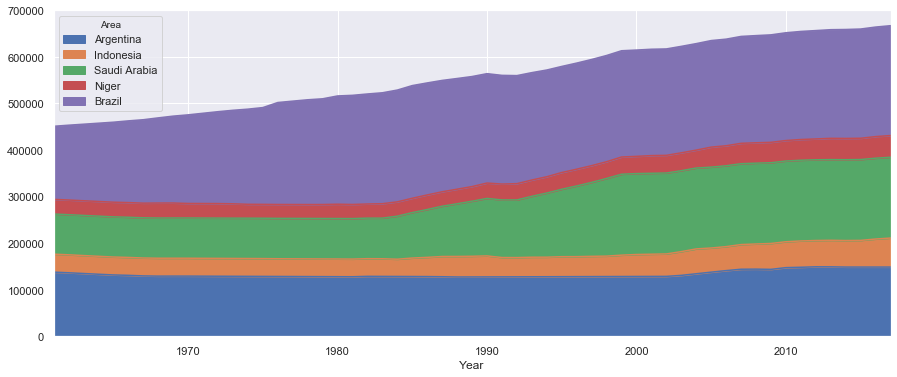

In [51]:
# plot the trend of agricultural areas in the 5 nations
land_use_ag.loc[ag_areas_diff[:5].index].T.plot.area(figsize=(15,6))

In [52]:
# forest areas (1000 ha) for each country per year
land_use_forest = land_use_all[land_use_all.Item == 'Forestry']
land_use_forest = land_use_forest[(land_use_forest.Area.isin(FAOSTAT_countries))]\
.groupby(["Area", "Year"])\
.Value.sum().unstack("Year")

In [53]:
# reduction of forest areas (2017 - 1997), minus values mean reduction of forest
forest_areas_diff = land_use_forest.iloc[:, 27] - land_use_forest.iloc[:,7]
forest_areas_diff = forest_areas_diff.sort_values(ascending=True)

In [54]:
# top 5 countries which experienced the biggest reduction of forest area
forest_areas_diff.head()

Area
Brazil                        -35365.3
Indonesia                     -14139.8
Nigeria                        -7373.1
Myanmar                        -7132.0
United Republic of Tanzania    -7060.0
dtype: float64

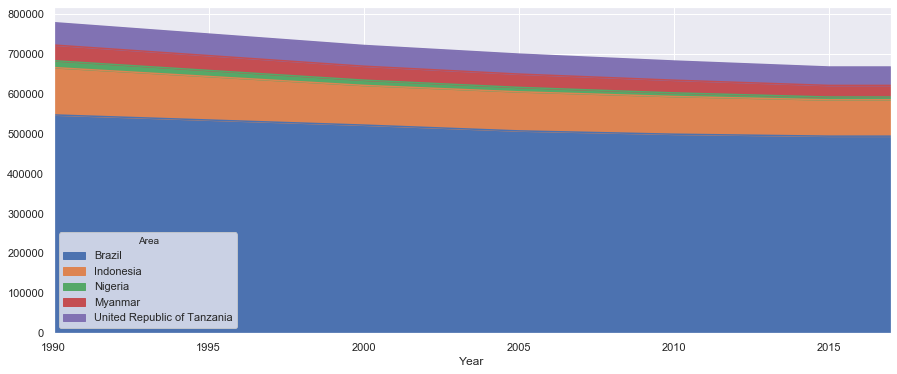

In [55]:
# plot the trend of forest areas in the 5 nations
land_use_forest.loc[forest_areas_diff[:5].index].T.plot.area(figsize=(15,6))

In [56]:
# dataframe to compare deforestation and expantion of agricultural area
df_concat = pd.concat([forest_areas_diff, ag_areas_diff], axis=1, sort=False)
df_concat.columns = ['d_ForestArea','d_AgriculturalArea']

df_concat = df_concat.sort_values(by=['d_AgriculturalArea'], ascending=False)
df_concat.head(10)

,d_ForestArea,d_AgriculturalArea
Argentina,-5627.90,20465.00
Indonesia,-14139.80,18773.00
Saudi Arabia,0.00,14827.00
Niger,-371.10,10600.00
Brazil,-35365.30,7906.36
Ethiopia,-1628.70,7048.10
United Republic of Tanzania,-7060.00,5947.00
Democratic Republic of the Congo,-5605.20,5828.00
China:mainland,37278.77,4400.00
Viet Nam,3755.20,4324.80


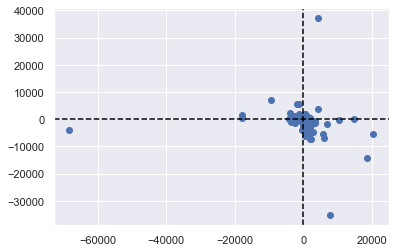

In [57]:
# create plot to find correlation between deforestation and expansion of agricultural area
fig = plt.figure()
ax = plt.subplot()
plt.scatter(df_concat.d_AgriculturalArea, df_concat.d_ForestArea)
plt.axvline(x=0,color='black', linestyle='--')
plt.axhline(y=0,color='black', linestyle='--')
plt.show()

In [60]:
# outlier 2: China:mainland
df_concat.loc['China:mainland']

d_ForestArea          37278.77
d_AgriculturalArea     4400.00
Name: China:mainland, dtype: float64

As explained in part 1, China:mainland enlarges its forest area by its continuous tree planting activity. This seems to draw out the effect of agricultural area expansion. So, we exclude China:mainland from the scattered plot.

(-10000, 5000)

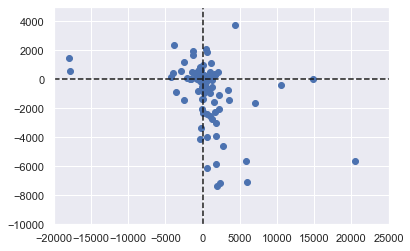

In [61]:
# reset xrange and yrange so that the outliers are excluded
fig = plt.figure()
ax = plt.subplot()
plt.scatter(df_concat.d_AgriculturalArea, df_concat.d_ForestArea)
plt.axvline(x=0,color='k', linestyle='--')
plt.axhline(y=0,color='k', linestyle='--')
ax.set_xlim(-20000,25000)
ax.set_ylim(-10000,5000)

> #### Explanation
> - We found slightly negative correlation between expansion of agrecultural areas and forest areas. However, the conrrelation is not as stong as we expected.
> - Considering only the expantion of agricultural areas is not enough to explain the main causes of deforestation. We need to consider other features such as timber production in the nation and planting activities as well.

# **Link between yield of agricultural land and deforestation**
Here we try to check if agricultural yield can be used useful in classifying the countries in de- and re-foresting ones.

In [16]:
prod_crops_all = pd.read_csv("data/faostat/Production_Crops_E_All_Data_cleared.csv", engine='python')

In [13]:
# top 10 deforested countries (criterion: surface of forest losses)
all_countries_forests_area_1990 = land_use_all[land_use_all.Item.str.match('Forestry') &   
                                               land_use_all.Element.str.match('Area') &
                                               (land_use_all.Year == 1990)]

all_countries_forests_area_2017 = land_use_all[land_use_all.Item.str.match('Forestry') &   
                                               land_use_all.Element.str.match('Area') &
                                               (land_use_all.Year == 2017)]

# drop aggregated rows
all_countries_forests_area_1990 = all_countries_forests_area_1990[all_countries_forests_area_1990['Area Code'] < 5000]
all_countries_forests_area_2017 = all_countries_forests_area_2017[all_countries_forests_area_2017['Area Code'] < 5000]

# join dataframes
deforestation_1990_2017 = all_countries_forests_area_1990.merge(all_countries_forests_area_2017, 
                                                                left_on=['Area Code', 'Area'], 
                                                                right_on=['Area Code', 'Area'])

# TODO: check non joint countries because of different names

# compute deforested areas
deforestation_1990_2017.loc[:, 'Forest land differential'] = deforestation_1990_2017['Value_y'] - deforestation_1990_2017['Value_x']
deforestation_1990_2017 = deforestation_1990_2017.loc[:, ['Area', 'Forest land differential']]\
                                                 .sort_values(by=['Forest land differential'], 
                                                              ascending=False)
# TODO: drop China:mainland

# extract name of top 10 countries for de- and re-forestation
top_10_deforested_countries = deforestation_1990_2017.tail(10).sort_values(by=['Forest land differential']).Area
top_10_reforested_countries = deforestation_1990_2017.head(11).Area
top_10_reforested_countries = top_10_reforested_countries.drop(38) # drop China:mainland

# get time series for those countries
top_10_deforested_countries_yearly = land_use_all[land_use_all.Item.str.match('Forestry') &   
                                                  land_use_all.Element.str.match('Area') &
                                                  land_use_all.Area.isin(top_10_deforested_countries)]
top_10_reforested_countries_yearly = land_use_all[land_use_all.Item.str.match('Forestry') &   
                                                  land_use_all.Element.str.match('Area') &
                                                  land_use_all.Area.isin(top_10_reforested_countries)]

In [14]:
# Correlation between low yield and high deforestation.
# The field 'Yield' in the 'Element' column of the dataframe is computed
# as 'Production' / 'Area Harvested' and measured in hg/ha
def yield_differences_in_top_10s(ITEM, YEAR):
    deforested_values = prod_crops_all.loc[(prod_crops_all.Area.isin(top_10_deforested_countries)) &
                                           (prod_crops_all.Item == ITEM) &
                                           (prod_crops_all.Year == YEAR) &
                                           (prod_crops_all.Element == 'Yield')]\
                                      .loc[:, ['Value', 'Area']]

    reforested_values = prod_crops_all.loc[(prod_crops_all.Area.isin(top_10_reforested_countries)) &
                                           (prod_crops_all.Item == ITEM) &
                                           (prod_crops_all.Year == YEAR) &
                                           (prod_crops_all.Element == 'Yield')]\
                                      .loc[:, ['Value', 'Area']]

    reforested_values['Deforested'] = 0
    reforested_values['Color'] = 'royalblue'
    deforested_values['Deforested'] = 1
    deforested_values['Color'] = 'orange'
    all_values = pd.concat([deforested_values, reforested_values], axis=0)
    all_values = all_values.sort_values(by=['Value'])

    # print(ITEM + ' yield:\n' +
    #       str(deforested_values.Value.mean()) + ' (mean over ' + str(deforested_values.Value.count()) + ' countries in top 10 deforested)\n' + 
    #       str(reforested_values.Value.mean()) + ' (mean over ' + str(reforested_values.Value.count()) + ' countries in top 10 reforested)')

    plt.figure(figsize=(9, 6))
    for country in all_values.Area:
        plt.barh(country, all_values.loc[all_values.Area == country, 'Value'], color=all_values.loc[all_values.Area == country, 'Color'])
    plt.legend(['reforested (== blue)', 'deforested (== orange)'])
    plt.title(ITEM + ' yield in top 10 reforested and deforested countries (year ' + str(YEAR) + ')')
    plt.gca().set_xlabel('Yield [hg/ha]')
    plt.show()

In [17]:
prod_crops_all.Item.unique()

array(['Almonds:with shell', 'Anise:badian:fennel:coriander', 'Apples',
       'Apricots', 'Barley', 'Berries nes', 'Cotton lint', 'Cottonseed',
       'Figs', 'Fruit:citrus nes', 'Fruit:fresh nes', 'Fruit:stone nes',
       'Grapes', 'Linseed', 'Maize', 'Melons:other (inc.cantaloupes)',
       'Millet', 'Nuts:nes', 'Olives', 'Onions:dry', 'Oranges',
       'Peaches and nectarines', 'Pears', 'Pistachios', 'Plums and sloes',
       'Potatoes', 'Pulses:nes', 'Rice:paddy', 'Seed cotton',
       'Sesame seed', 'Spices:nes', 'Sugar beet', 'Sugar cane',
       'Sunflower seed', 'Vegetables:fresh nes', 'Walnuts:with shell',
       'Watermelons', 'Wheat', 'Cereals (Rice Milled Eqv)',
       'Cereals:Total', 'Citrus Fruit:Total', 'Coarse Grain:Total',
       'Fibre Crops Primary', 'Fruit Primary', 'Oilcrops:Cake Equivalent',
       'Oilcrops:Oil Equivalent', 'Pulses:Total',
       'Roots and Tubers:Total', 'Treenuts:Total', 'Vegetables Primary',
       'Beans:dry', 'Beans:green', 'Broad beans:h

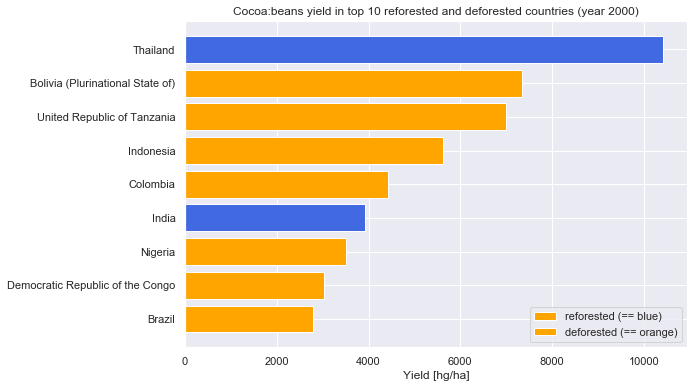

In [18]:
yield_differences_in_top_10s('Cocoa:beans', 2000)
# yield_differences_in_top_10s('Maize', 2000)

> #### ***Explanation***
> Countries that **increased their forest land** (USA, Chine, Thailand, France, Spain...) have usually a much **bigger yield**. Yield is computed as production over area harvested and it is than measured in hg/ha. This can be interpreted as: **better productivity means less need of agriculture land** to product the same quantity, alleviating the need of new lands to cultivate. Anyway **this conclusion is weak** since the clear correlation exibithed in the previous plots can be explained also by a more general cause: deforesting countries are on average less rich than the ones that increase tree coverage; **richer countries have access to better agricultural practices** that increase productivity (e.g. check for India, developing country, which has low productivity scores).
>
> (TODO: fix problem with the legend for the data story!)

# **Clustering of the countries based on agricultural production share**
In this section we want to **understand if the deforesting countries have similar agriculture styles**. **PCA** is used to classify the countries based on their agricultural production in a 2D space. A matrix containing countries (as rows) and **shares in agricultural production** of each type of product (each item is a column) is used as a representation of different agriculture styles.

In [20]:
# compute the share of each agriculture item for every country, selected year
YEAR = 2015

countries_production_total = prod_crops_all.loc[(prod_crops_all.Element == 'Production')]\
                                           .groupby(['Area', 'Year'])\
                                           .sum()\
                                           .rename({'Value': 'Total Yearly Production'}, axis='columns')\
                                           .loc[:, 'Total Yearly Production']

countries_production_shares = prod_crops_all.loc[(prod_crops_all.Element == 'Production')]\
                                            .merge(countries_production_total, right_index=True, left_on=['Area', 'Year'])

countries_production_shares['Yearly Share'] = 100 * countries_production_shares['Value'] / countries_production_shares['Total Yearly Production']

# remove aggregated areas
countries_production_shares = countries_production_shares.loc[countries_production_shares['Area Code'] < 5000]

# select a single year
shares_single_year = countries_production_shares.loc[countries_production_shares.Year == YEAR]

In [22]:
# load agricultural share matrix from file
production_shares_matrix = pd.read_pickle("./production_shares_matrix.pkl")

In [23]:
# show a sample of the matrix used for clustring
production_shares_matrix.iloc[0:4, 0:4]

,Almonds:with shell,Anise:badian:fennel:coriander,Apples,Apricots
Afghanistan,0.0976835,0.0725193,0.361521,0.353274
Albania,0,0,1.45978,0.0802803
Algeria,0.157873,0,0.931925,0.605811
American Samoa,0,0,0,0


In [24]:
# distance between two countries in agricultural share space
def compute_distance(country_1, country_2):
    country_1_agricultural_share = np.array(production_shares_matrix.loc[country_1, :].values)
    country_2_agricultural_share = np.array(production_shares_matrix.loc[country_2, :].values)
    cosine_similarity = np.dot(country_1_agricultural_share, country_2_agricultural_share) / \
                        (np.linalg.norm(country_1_agricultural_share) * np.linalg.norm(country_2_agricultural_share))
    return 1 - cosine_similarity

In [25]:
# compute (cosine) distance matrix between top 10 re- and de-forested
distance_matrix = np.zeros((20, 20))
the_20_countries = top_10_reforested_countries.append(top_10_deforested_countries)
for i, country_1 in enumerate(the_20_countries):
    for j, country_2 in enumerate(the_20_countries):
        distance_matrix[i, j] = compute_distance(country_1, country_2)
distances = pd.DataFrame(data=distance_matrix,
                         index=the_20_countries,
                         columns=the_20_countries)
# set 0 on diagonal (sometimes is 2e-16)
for i in range(20):
    distances.iloc[i, i] = 0

In [26]:
countries_centers = pd.DataFrame([['China', 35.86166, 104.195397], 
                                  ['United States of America', 37.09024, -95.712891],
                                  ['India', 20.593684, 78.96288],
                                  ['Viet Nam', 14.058324, 108.277199], 
                                  ['Spain', 40.463667, -3.74922],
                                  ['France', 46.227638, 2.213749], 
                                  ['Chile', -35.675147, -71.542969],
                                  ['Thailand', 15.870032, 100.992541], 
                                  ['Turkey', 38.963745, 35.243322],
                                  ['Italy', 41.87194, 12.56738], 
                                  ['Brazil', -14.235004, -51.92528], 
                                  ['Indonesia', -0.789275, 113.921327],
                                  ['Nigeria', 9.081999, 8.675277],
                                  ['Myanmar', 21.913965, 95.956223], 
                                  ['United Republic of Tanzania', -6.369028, 34.888822],
                                  ['Zimbabwe', -19.015438, 29.154857], 
                                  ['Bolivia (Plurinational State of)', -16.290154, -63.588653],
                                  ['Democratic Republic of the Congo', -4.038333, 21.758664], 
                                  ['Argentina', -38.416097, -63.616672],
                                  ['Colombia', 4.570868, -74.297333]],
                                 columns=['Area', 'Latitude', 'Longitude'])
countries_centers = countries_centers.set_index('Area')

In [31]:
# colors
reforested_color = '#1f77b4'
deforested_color = '#ff7f0e'
colors = []
for i in range(10):
    colors.append(reforested_color)
for i in range(10):
    colors.append(deforested_color)

# extract forest land differential and use it to define the scale of the bubbles
top_10_reforested_sizes = deforestation_1990_2017.head(11)\
                                                 .drop(38)\
                                                 .loc[:, 'Forest land differential']\
                                                 .tolist()
top_10_deforested_sizes = deforestation_1990_2017.tail(10)\
                                                 .sort_values(by=['Forest land differential'])\
                                                 .loc[:, 'Forest land differential']\
                                                 .tolist()
top_10_deforested_sizes = np.abs(top_10_deforested_sizes).tolist()  # differentials for deforested are negative

# rescale using 
sizes = top_10_reforested_sizes + top_10_deforested_sizes
sizes = sizes / np.max(sizes)
sizes = np.log(sizes + 1)

# final absolute scale to match plotly parameters
scale = 50
for i in range(len(sizes)):
    sizes[i] = sizes[i] * scale

In [28]:
fig = go.Figure()

# add bubbles representing forest land differential between 1990 and 2017 for selected countries
fig.add_trace(go.Scattergeo(
    lon = countries_centers['Longitude'],
    lat = countries_centers['Latitude'],
    hoverinfo = 'text',
    text = countries_centers.index,
    mode = 'markers',
    marker = dict(
        size = sizes,
        color = colors,
        opacity = 1,
        line = dict(
            width = 3,
            color = 'rgba(68, 68, 68, 0)'
        )
    )))

fig.update_layout(showlegend = True)

# add connections between countries based on distance in agricultural production share
connections = []
for i, country_1 in enumerate(the_20_countries):
    for j, country_2 in enumerate(the_20_countries):
        
        # skip diagonal
        if country_1 == country_2:
            continue
            
        # threshold for distance
        distance = distances.loc[country_1, country_2]
        if distance > 0.2:
            continue
        
        if (country_1 in top_10_reforested_countries.tolist()) & (country_2 in top_10_reforested_countries.tolist()):
            line_color = reforested_color
        elif (country_1 in top_10_deforested_countries.tolist()) & (country_2 in top_10_deforested_countries.tolist()):
            line_color = deforested_color
        else:
            line_color = 'grey'
        # add connection
        fig.add_trace(
            go.Scattergeo(
                lon = [countries_centers.loc[country_1].Longitude, countries_centers.loc[country_2].Longitude],
                lat = [countries_centers.loc[country_1].Latitude, countries_centers.loc[country_2].Latitude],
                mode = 'lines',
                line = dict(width = 0.3/distance, color = line_color),
                opacity = 0.3
            )
        )
        
fig.update_layout(
    title_text = '',
    showlegend = False,
    geo = go.layout.Geo(
        showland = True,
        landcolor = 'rgb(243, 243, 243)',
        countrycolor = 'rgb(204, 204, 204)',
    ),
)
fig.update_layout(
    legend=go.layout.Legend(
        x=0,
        y=1,
        traceorder="normal",
        font=dict(
            family="sans-serif",
            size=12,
            color="black"
        ),
        bgcolor="LightSteelBlue",
        bordercolor="Black",
        borderwidth=2
    )
)

fig.show()

In [339]:
top_10_reforested_countries

37                        China
185    United States of America
83                        India
190                    Viet Nam
165                       Spain
62                       France
36                        Chile
171                    Thailand
178                      Turkey
90                        Italy
Name: Area, dtype: object

In [82]:
top_10_deforested_countries

22                               Brazil
84                            Indonesia
128                             Nigeria
118                             Myanmar
184         United Republic of Tanzania
195                            Zimbabwe
20     Bolivia (Plurinational State of)
48     Democratic Republic of the Congo
8                             Argentina
39                             Colombia
Name: Area, dtype: object

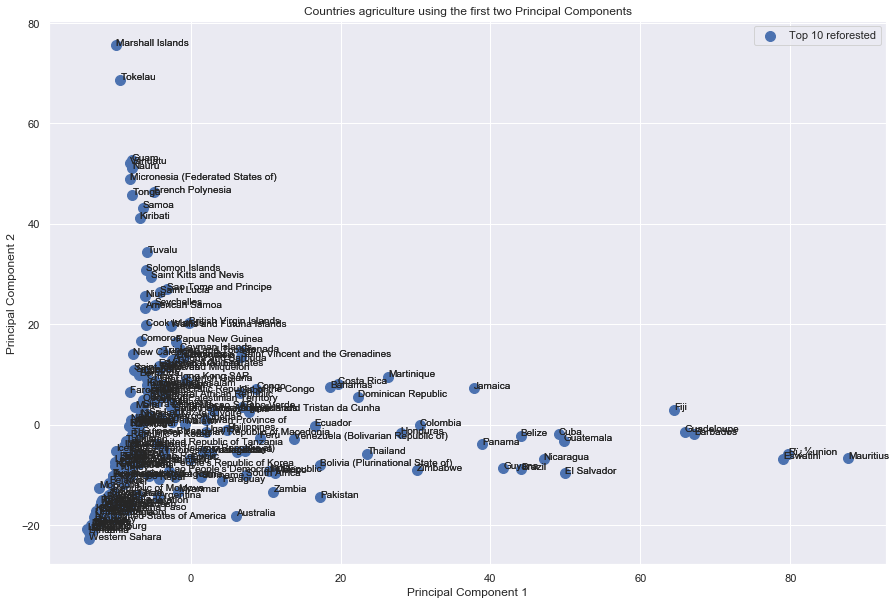

In [80]:
from sklearn.decomposition import PCA

# PCA on the whole agricultural share matrix (all countries)

# matrix rows are countries, columns are products; values are shares (%) of total yearly production
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(production_shares_matrix.values)
principalDf = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])

# plot results in 2D and look for clusters
plt.figure(figsize=(15, 10))
plt.scatter(principalDf.PC1, principalDf.PC2, marker='o', s=100)
# add country names to the plot
for i, country in enumerate(production_shares_matrix.index.values):
    plt.annotate(country, (principalDf.PC1[i], principalDf.PC2[i]))
for i, country in enumerate(production_shares_matrix.index.values):
    plt.annotate(country, (principalDf.PC1[i], principalDf.PC2[i]))
plt.title('Countries agriculture using the first two Principal Components')
plt.gca().set_xlabel('Principal Component 1')
plt.gca().set_ylabel('Principal Component 2')
plt.legend(['Top 10 reforested', 'Top 10 deforested'])
plt.show()

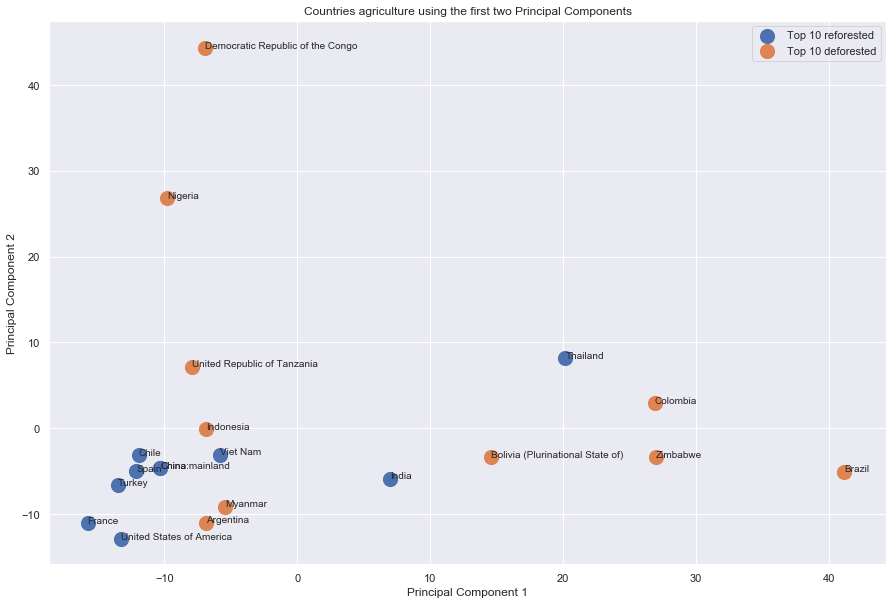

In [125]:
from sklearn.decomposition import PCA

# PCA on top 10 re- and de-forester countries

# compute the reduced matrix (only 20 countries from the two top 10) before applying SVD
reduced_production_shares_matrix = production_shares_matrix.loc[production_shares_matrix.index.isin(top_10_deforested_countries.values.tolist() + 
                                                                                                    top_10_reforested_countries.values.tolist())]

# find top 10 re- and de-forester countries indices (rows) in the matrix
reduced_deforester_indices = []
reduced_reforester_indices = []
for i in range(0, reduced_production_shares_matrix.shape[0]):
    if reduced_production_shares_matrix.index[i] in top_10_deforested_countries.values:
        reduced_deforester_indices.append(i)
    elif reduced_production_shares_matrix.index[i] in top_10_reforested_countries.values:
        reduced_reforester_indices.append(i)
        
# matrix rows are countries, columns are products; values are shares (%) of total yearly production
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(reduced_production_shares_matrix.values)
principalDf = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])

# plot results in 2D and look for clusters
plt.figure(figsize=(15, 10))
plt.scatter(principalDf.PC1[reduced_reforester_indices], principalDf.PC2[reduced_reforester_indices], marker='o', s=200)
plt.scatter(principalDf.PC1[reduced_deforester_indices], principalDf.PC2[reduced_deforester_indices], marker='o', s=200)
# add country names to the plot
for i, country in enumerate(reduced_production_shares_matrix.index.values[reduced_reforester_indices]):
    plt.annotate(country, (principalDf.PC1[reduced_reforester_indices[i]], principalDf.PC2[reduced_reforester_indices[i]]))
for i, country in enumerate(reduced_production_shares_matrix.index.values[reduced_deforester_indices]):
    plt.annotate(country, (principalDf.PC1[reduced_deforester_indices[i]], principalDf.PC2[reduced_deforester_indices[i]]))
plt.title('Countries agriculture using the first two Principal Components')
plt.gca().set_xlabel('Principal Component 1')
plt.gca().set_ylabel('Principal Component 2')
plt.legend(['Top 10 reforested', 'Top 10 deforested'])
plt.show()

In [124]:
# first 10 singular values
N = 5
pca_singular_values = PCA(n_components=N)
pca_singular_values.fit_transform(reduced_production_shares_matrix.values)
print("First " + str(N) + " singular values:\n", pca_singular_values.singular_values_, end='\n\n')

# variance explanation ratio for each singular value
print("Variance explanation of the first " + str(N) + " singular values:\n", pca_singular_values.explained_variance_ratio_)

First 5 singular values:
 [72.7103547  59.36180494 36.38818324 30.07216008 24.19752362]

Variance explanation of the first 5 singular values:
 [0.41425953 0.27611766 0.10375302 0.07086132 0.04587983]


>#### ***Explanation***
> **PCA** is used to classify the countries based on their agricultural production in a 2D space.
> + Pros:
>
>   + Simple **visual** clustering.
>
>   + **Deforesting countries** (orange) **have a more spread distribution** and are on average far from the blue cluster of countries that increase forest land. 
>
> + Cons: 
>
>   + **Lack of interpretability** since the dimensions does not have a physical meaning.
>
>   + The clustering in two classes is far from perfect.
>   
>   + The difference between the two biggest singular values and the others is not so high (the third is about half the second): **not-negligible variations are thrown away** with just 2 dimensions.

## **APPENDIX: datasets summaries**

#### Inputs_LandUse_E_All_Data_cleared.csv
+ **Unit**: [**'1000 ha'**, 'million tonnes']
+ **Item**: ['Country area', 'Land area', 'Agriculture', ..., **'Forestry'**, **'Forest land'**, **'Primary Forest'**, ..., **'Farm buildings & farmyards'**, 'Perm. meadows & pastures area certified organic', ...]
+ **Element**: ['Area', 'Carbon stock in living biomass']

#### Environment_LandUse_E_All_Data_cleared.csv
+ **Unit**: [**'%'**]
+ **Item**: ['Arable land', 'Land under permanent crops', 'Cropland', 'Land under perm. meadows and pastures', 'Agriculture area actually irrigated', 'Land area equipped for irrigation', 'Agricultural land', **'Forest land'**, **'Primary Forest'**, **'Planted Forest'**, **'Other naturally regenerated forest'**, 'Agriculture area under organic agric.']
+ **Element**: ['Share in Agricultural land', **'Share in Land area'**, **'Share in Forest land'**]

#### Environment_LandCover_E_All_Data_cleared.csv
+ **Unit**: ['1000 ha']
+ **Item**: ['Artificial surfaces (including urban and associated areas)', **'Herbaceous crops'**, **'Woody crops'**, 'Multiple or layered crops', **'Grassland'**, **'Tree-covered areas'**, 'Mangroves', 'Shrub-covered areas', 'Shrubs and/or herbaceous vegetation:aquatic or regularly flooded', 'Sparsely natural vegetated areas', 'Terrestrial barren land', 'Permanent snow and glaciers', 'Inland water bodies', 'Coastal water bodies and intertidal areas']
+ **Element**: ['Area from **MODIS**', 'Area from **CCI_LC**']

#### Production_CropsProcessed_E_All_Data_cleared.csv
+ **Unit**: ['tonnes']
+ **Item**: ['Cotton lint', 'Cottonseed', 'Molasses', 'Oil:cottonseed', ..., **'Oil:palm kernel'**, 'Palm kernels', 'Oil:maize']
+ **Element**: ['Production']

#### Production_Crops_E_All_Data_cleared.csv
+ **Unit**: ['ha', 'hg/ha', 'tonnes']
+ **Item**: ['Almonds:with shell', 'Anise:badian:fennel:coriander', 'Apples', ..., ..., **'Soybeans'**, ..., ..., ..., ..., 'Fruit:pome nes']
+ **Element**: [**'Area harvested'**, **'Yield'**, **'Production'**]

#### Environment_LivestockPatterns_E_All_Data_cleared.csv
+ **Unit**: [**'LSU/ha'**, '% of total LSU', **'Livestock units (LSU)'**]
+ **Item**: ['Asses', 'Camels', **'Cattle'**, 'Chickens', 'Goats', 'Horses', 'Mules', 'Sheep', 'Cattle and Buffaloes', 'Sheep and Goats', 'Equidae', **'Major livestock types'**, 'Buffaloes', 'Pigs']
+ **Element**: ['Livestock units per agricultural land area', 'Share in total livestock', 'Stocks']

#### Production_LivestockProcessed_E_All_Data_cleared.csv
+ **Unit**: ['tonnes']
+ **Item**: ['Butter and ghee:sheep milk', 'Butter:cow milk', ..., 'Cheese:buffalo milk', 'Butter of goat mlk']
+ **Element**: ['Production']

#### Production_LivestockPrimary_E_All_Data_cleared.csv
+ **Unit**: ['1000 Head', '100mg/An', 'tonnes', '1000 No', **'Head'**, 'hg/An', '0.1g/An', 'hg', 'No']
+ **Item**: ['Eggs:hen:in shell', 'Eggs:hen:in shell (number)', 'Hides:cattle:fresh', 'Honey:natural', 'Meat indigenous:camel', **'Meat indigenous:cattle'**, ..., Snails:not sea', 'Hair:horse']
+ **Element**: ['Laying', 'Yield', 'Production', 'Producing Animals/Slaughtered', 'Yield/Carcass Weight', 'Milk Animals', 'Prod Popultn']